In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from functools import reduce

import squarify as sq

import folium
from folium.plugins import HeatMap

from sklearn.cluster import KMeans

from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest

import urllib
from io import BytesIO 
import requests

import warnings
warnings.filterwarnings('ignore')

## Loading files and denormalize the from OLTP system

In [2]:
# replace the product categorie names to english
products = pd.read_csv("olist_products_dataset.csv")
prod_cat_name_tr = pd.read_csv("product_category_name_translation.csv")
products = products.merge(prod_cat_name_tr, on='product_category_name', how='left')
products.drop ('product_category_name', axis=1, inplace=True)

In [3]:
#load all the tables
data_order_items = pd.read_csv("olist_order_items_dataset.csv")
data_orders = pd.read_csv("olist_orders_dataset.csv")
data_sellers = pd.read_csv("olist_sellers_dataset.csv")
data_order_payments = pd.read_csv("olist_order_payments_dataset.csv")
data_customers = pd.read_csv("olist_customers_dataset.csv")
data_products = pd.read_csv ("olist_products_dataset.csv")

Now we can join (or merge) all the data into one. Let's disregard the 'data_order_payments' and 'data_order_reviews' data sets for now. Each 'order_id' can have several types of payments and reviews, which in our merge process will cause duplicates in the data and interfere with continuous measures, such as price.

In [4]:
#list with datasets with PK and FK 'order_id'
ordersList = [data_orders, data_order_items]

#merge, join multiple datasets with the same FK:
data = reduce(lambda data1, data2: pd.merge(data1, data2, on='order_id', how='left'), ordersList)

data = pd.merge(data, data_products, on='product_id', how='outer')

data = pd.merge(data, data_sellers, on='seller_id', how='outer')

#merge final data with the same FK (customer_id):
data = pd.merge(data, data_customers, on='customer_id', how='outer')

## EDA - Exploratory Data Analysis

In [5]:
# De-normalized data - All datasets together, OLAP.
print('columns:', data.columns)
print('shape:', data.shape)

columns: Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'product_category_name',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'seller_zip_code_prefix',
       'seller_city', 'seller_state', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state'],
      dtype='object')
shape: (113425, 29)


#### Find null data around dataset

In [6]:
type_and_missing = pd.concat([data.isna().sum().sort_values(ascending = False), 
                              ((data.isna().sum()/data.isna().count())*100).sort_values(ascending=False), 
                              data.dtypes], axis=1, keys=['Total', 'Missing_%','Type'])
type_and_missing[type_and_missing['Total'] > 0]

,Total,Missing_%,Type
order_delivered_customer_date,3229,2.846815,object
product_category_name,2378,2.096540,object
product_photos_qty,2378,2.096540,float64
product_description_lenght,2378,2.096540,float64
product_name_lenght,2378,2.096540,float64
order_delivered_carrier_date,1968,1.735067,object
product_width_cm,793,0.699140,float64
product_height_cm,793,0.699140,float64
product_length_cm,793,0.699140,float64
product_weight_g,793,0.699140,float64


To determine the meaning of nulls, let's understand the order status for each column that contains nulls. So we found out, for example, that when we have nulls in the fields linked to 'seller', it's because the purchase was not completed, since the corresponding statuses are ['unavailable', 'canceled', 'created', 'shipped', ' invoiced'], without 'delivered'.

As for the variables linked to the characteristics of the products that contain null values, it was probably a lack of completion. Same case for reviews.

In the future, we can divide the dataset into purchases that have been completed and that have not been completed, in order to facilitate future analysis.

In [7]:
data.loc[data.seller_id.isna()]['order_status'].value_counts()
# data.loc[(data.seller_id.isna()) & (data.order_status == 'shipped')]

unavailable    603
canceled       164
created          5
invoiced         2
shipped          1
Name: order_status, dtype: int64

We have to consider that the data were normalized, with relationships between them. So a single purchase has a unique 'order_id' but may appear multiple times in the dataset as it may have more than one product, more than one payment method, more than one seller, etc. It is not a Primary Key. So we must calculate the averages always considering the value of unique sales, not the frequency.

In [8]:
data.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 161
order_delivered_carrier_date     1968
order_delivered_customer_date    3229
order_estimated_delivery_date       0
order_item_id                     775
product_id                        775
seller_id                         775
shipping_limit_date               775
price                             775
freight_value                     775
product_category_name            2378
product_name_lenght              2378
product_description_lenght       2378
product_photos_qty               2378
product_weight_g                  793
product_length_cm                 793
product_height_cm                 793
product_width_cm                  793
seller_zip_code_prefix            775
seller_city                       775
seller_state                      775
customer_unique_id                  0
customer_zip

In [9]:
# filling missing valuse for price feature 
from sklearn.impute import KNNImputer
data['price'] = KNNImputer(n_neighbors=4).fit_transform(data['price'].values.reshape(-1,1))
data['price'].isnull().sum()

0

In [10]:
# Correction dates
data['order_purchase_timestamp'] = pd.to_datetime(data.order_purchase_timestamp)
data['order_approved_at'] = pd.to_datetime(data.order_approved_at)
data['order_delivered_carrier_date'] = pd.to_datetime(data.order_delivered_carrier_date)
data['order_delivered_customer_date'] = pd.to_datetime(data.order_delivered_customer_date)
data['order_estimated_delivery_date'] = pd.to_datetime(data.order_estimated_delivery_date)
data['shipping_limit_date'] = pd.to_datetime(data.shipping_limit_date)

### Summary of valuable features

In [11]:
totalOrders = data_orders.order_id.nunique()

print('Unique customer cities:',data.customer_city.nunique())
print('Unique customer states:',data.customer_state.nunique())
print('Unique seller states:',data.seller_state.nunique())
print('Average price:',data.price.sum() / totalOrders)
print('Average qnt of products by order:',data.order_item_id.sum() / totalOrders)
print('Average freight price:',data.freight_value.sum() / totalOrders)
print('Total revenue for the period was:',data.price.sum())
print('Number of unique customers:',data.customer_unique_id.nunique())
print('Total order quantity:', totalOrders)
print('Average number of product by order:',data.freight_value.sum() / totalOrders)

Unique customer cities: 4119
Unique customer states: 27
Unique seller states: 23
Average price: 137.62080377044026
Average qnt of products by order: 1.3569453243631902
Average freight price: 22.64568477790851
Total revenue for the period was: 13685150.347736351
Number of unique customers: 96096
Total order quantity: 99441
Average number of product by order: 22.64568477790851


In [12]:
# price feature
priceGrouped = data.groupby('order_id')['price'].sum()
priceGrouped.describe()

count    99441.000000
mean       137.620804
std        209.828081
min          0.850000
25%         45.990000
50%         88.000000
75%        149.900000
max      13440.000000
Name: price, dtype: float64

<AxesSubplot:xlabel='price'>

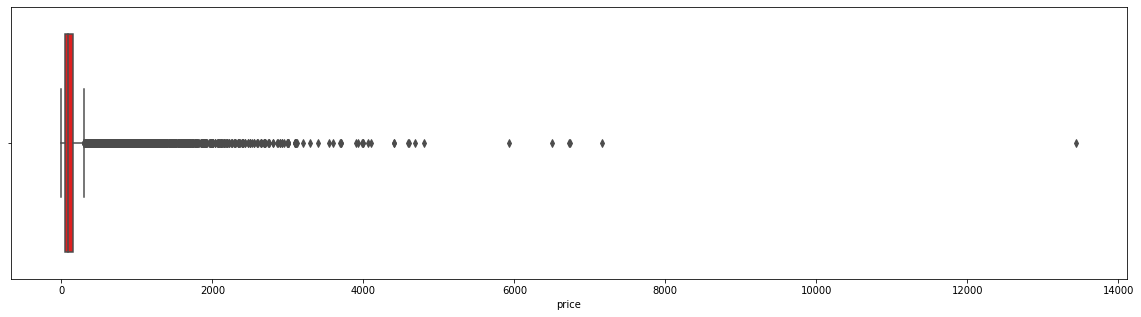

In [13]:
#Data Order Prices Analysis
plt.figure(figsize=(20,5))
sns.boxplot(x=priceGrouped, color='red')

## Time series forecast (sum of sales figures)

To predict the sum of the sales value for the coming weeks, we are going to use an ARIMA model

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

dataTime = data[['order_id', 'order_purchase_timestamp', 'price']].set_index('order_purchase_timestamp', inplace=False)

dataTimeMean = pd.DataFrame(dataTime.resample('W')['price'].sum()) #resample using weeks as parameter
# dataTimeMean = dataTimeMean.fillna(0)
dataTimeMean.drop(dataTimeMean.tail(8).index, inplace=True) # Drop the last observations with 0 

#Decompose Time Series
decompose = seasonal_decompose(dataTimeMean, extrapolate_trend=12)

#Trend
obs = decompose.observed
#Trend
trend = decompose.trend
#Seazonal
seazon = decompose.seasonal
#Error
random = decompose.resid

<AxesSubplot:xlabel='order_purchase_timestamp', ylabel='resid'>

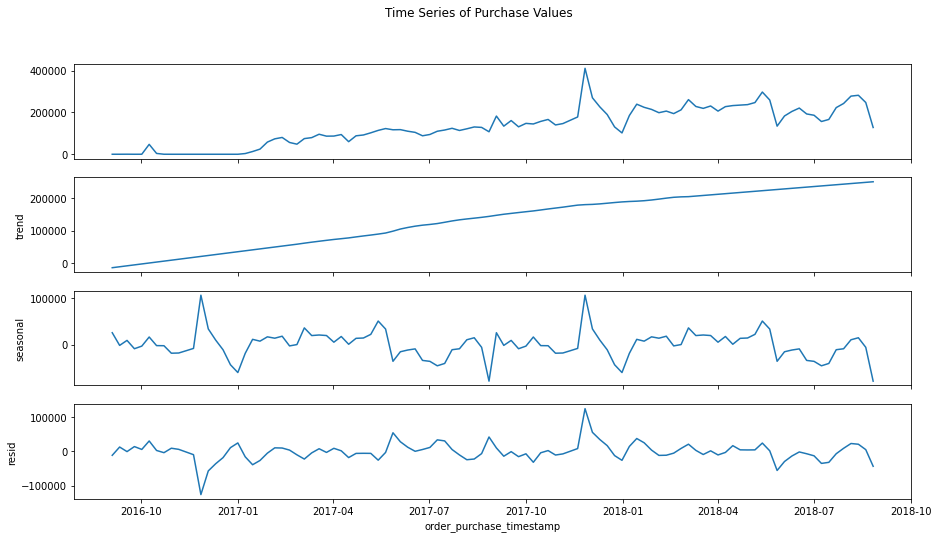

In [15]:
#plot
fig, axes = plt.subplots(4, 1, figsize=(15,8), sharex=True)
fig.suptitle('Time Series of Purchase Values')

sns.lineplot(x=obs.index, y=obs, ax=axes[0], data=obs)
sns.lineplot(x=trend.index, y=trend, ax=axes[1], data=trend)
sns.lineplot(x=seazon.index, y=seazon, ax=axes[2], data=seazon)
sns.lineplot(x=random.index, y=random, ax=axes[3], data=random)

In [16]:
#Is the data stationary?
adfTest = ADFTest(alpha=0.05)
adfTest.should_diff(dataTimeMean)

(0.12126820508357695, True)

In [17]:
dataTimeMean['x1'] = dataTimeMean.price.shift(1)

dataTimeMean.dropna(axis=0, inplace=True)

dataTimeMean.head()

,price,x1
order_purchase_timestamp,,
2016-09-11,59.500000,72.890000
2016-09-18,255.623739,59.500000
2016-09-25,0.000000,255.623739
2016-10-02,100.000000,0.000000
2016-10-09,47283.588607,100.000000


<AxesSubplot:xlabel='order_purchase_timestamp'>

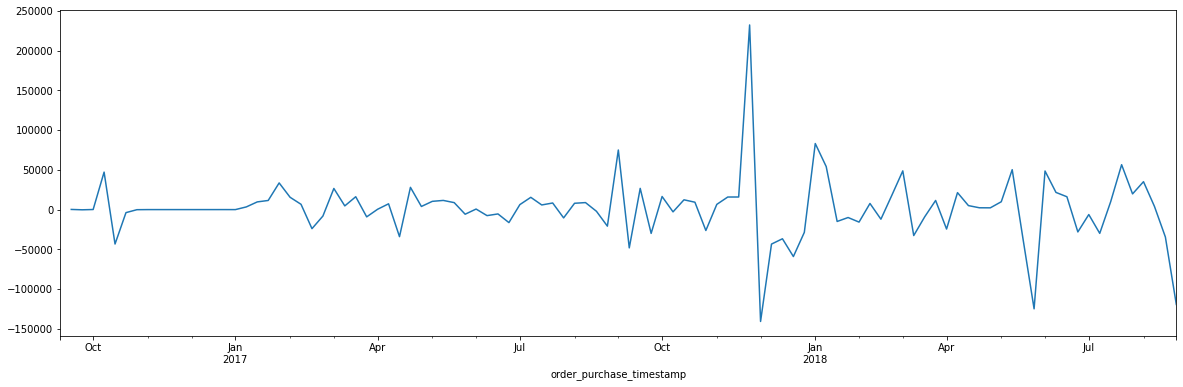

In [18]:
#Making the series stationary
dataTimeMean.price.diff(1).plot(figsize=(20, 6))

<AxesSubplot:xlabel='order_purchase_timestamp'>

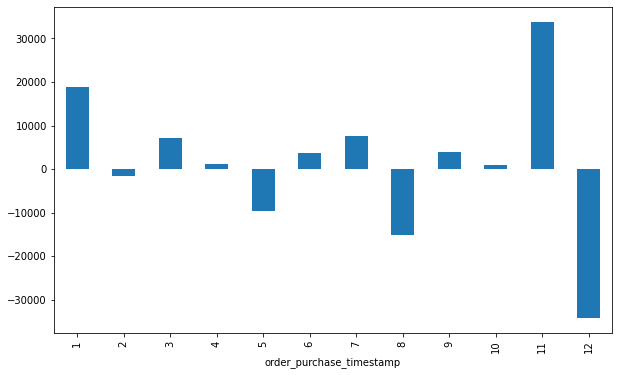

In [19]:
dataTimeMean.price.diff(1).groupby(dataTimeMean.index.month).mean().plot(kind='bar', figsize=(10, 6))

Decomposing the data, we noticed a strong downward trend in values according to seasonality, at the end of each year, in December, probably after an up caused by the Black Friday.

Let's investigate the autocorrelation factor to understand better what parameters we should use.We then noticed a strong downward trend in values according to seasonality, at the end of each year.

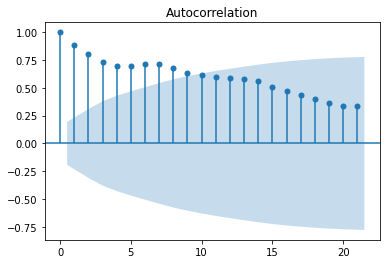

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(dataTimeMean.price)
plt.show()

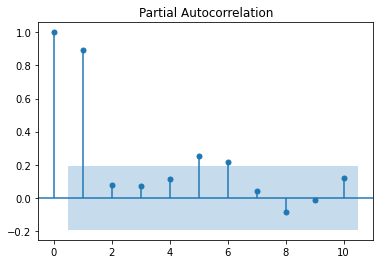

In [21]:
plot_pacf(dataTimeMean.price, lags=10)
plt.show()

As observed on Partial Autocorrelation plot, a shift of 1 will be sufficient for a regression model. So, we will create this new feature to apply a regression model to forecast next week's price.

## Find the best regression model

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X = dataTimeMean[['x1']]
y = dataTimeMean.price.values

linearRegression = LinearRegression().fit(X, y)
predictionsLinear = linearRegression.predict(X)

print('RMSE for Linear Regression was: \n', mean_squared_error(y, predictionsLinear, squared=False))

RMSE for Linear Regression was: 
 38701.39076321583


In [23]:
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=150, learning_rate=0.05)
xgb.fit(X, y, 
        early_stopping_rounds=5, 
        eval_set=[(X, y)], 
        verbose=False
)

predictions_XGBoost = xgb.predict(X)

print('RMSE for xgb was: \n', mean_squared_error(y, predictions_XGBoost, squared=False))

RMSE for xgb was: 
 7057.4852492264445


In [24]:
from sklearn.ensemble import RandomForestRegressor
randomF = RandomForestRegressor(n_estimators = 500, random_state=0).fit(X, y)

predictions_RandomForest = randomF.predict(X)
print('RMSE for Random Forest was: \n', mean_squared_error(y, predictions_RandomForest, squared=False))

RMSE for Random Forest was: 
 16356.959972393332


So, we will choose XGB Regressor.

<AxesSubplot:xlabel='order_purchase_timestamp'>

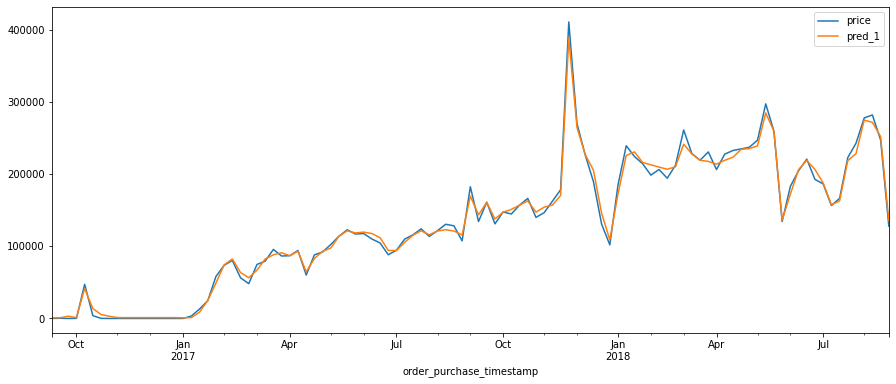

In [25]:
dataTimeMean['pred_1'] = xgb.predict(X)
dataTimeMean[['price', 'pred_1']].plot(figsize=(15, 6))

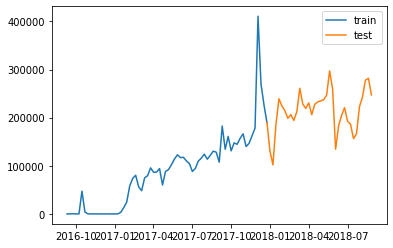

In [26]:
train_size = int(len(dataTimeMean.price) * 2 / 3)

train = X[:train_size]
test = X[train_size-1:]

plt.plot(train)
plt.plot(test)
plt.legend(['train', 'test'])

Let's see how the model XGB Regressor fits on unseen data (test set)

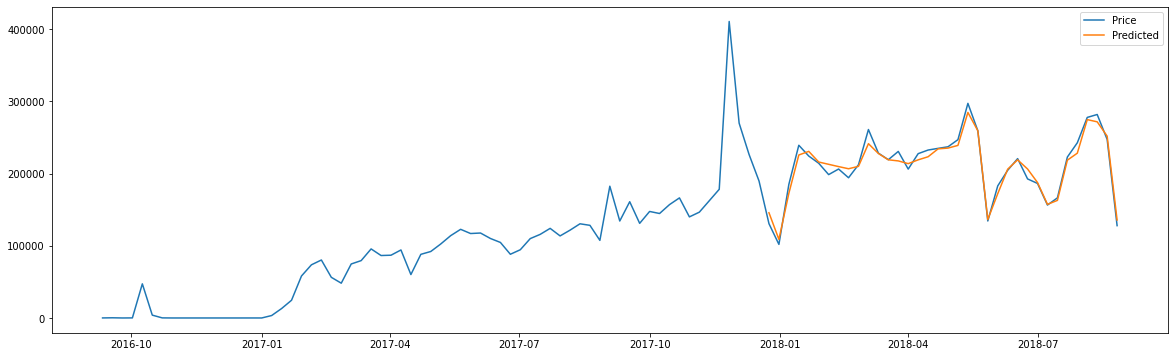

In [27]:
plt.figure(figsize=(20, 6))
plt.plot(dataTimeMean.price)
forecast = xgb.predict(test)
plt.plot(test.index, forecast)
plt.legend(['Price', 'Predicted'])

We will now forecast the next week's "price" feature, using the trainned XGB model

In [28]:
lastPrice = dataTimeMean['price'][-1]

datesToPredict = pd.Series(dataTimeMean.index[-1] + pd.Timedelta('1 w'))

forecastData =  pd.DataFrame({'x1': str(lastPrice)}, index=datesToPredict)  
forecastData.x1 = pd.to_numeric(forecastData.x1)


print("Next week's predicted price is: R$", xgb.predict(forecastData))

Next week's predicted price is: R$ [115646.1]


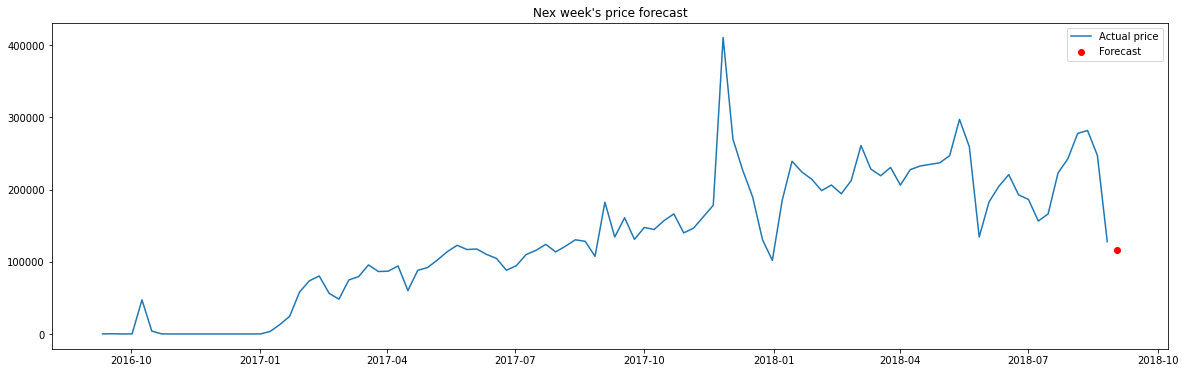

In [29]:
plt.figure(figsize=(20, 6))
plt.plot(dataTimeMean.price)
forecast = xgb.predict(test)
plt.scatter(forecastData.index, xgb.predict(forecastData), color='red')
plt.title("Nex week's price forecast")
plt.legend(['Actual price', 'Forecast'])

### Applying auto-ARIMA model as an option for goal defining for next weeks

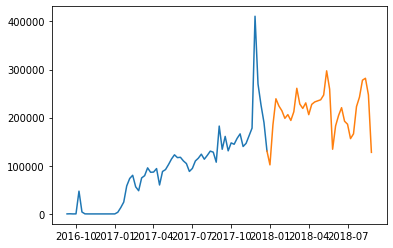

In [30]:
#Delete data generated from XGB
dataTimeMean = dataTimeMean.drop(columns=['pred_1', 'x1'], axis=0)

train = dataTimeMean[:train_size]
test = dataTimeMean[train_size-1:]

plt.plot(train)
plt.plot(test)

In [31]:
autoArimaModel = auto_arima(train, m=12, seazonal=False, 
                            trace=False, random_state=1, n_fits=50)

autoArimaModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   68
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -662.618
Date:                            Wed, 02 Feb 2022   AIC                           1331.236
Time:                                    21:47:27   BIC                           1337.312
Sample:                                         0   HQIC                          1333.592
                                             - 68                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.613e+04   8261.624      1.952      0.051     -66.285    3.23e+04
ar.L1          0.6049      0.132      4.588      0.000       0.346       0.863
sigma2      1.125e+09      0.062    1.8e+10      0.000    1.12e+09    1.12e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               278.96
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               4.69   Skew:                             2.22
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.24e+25. Standard errors may be unstable.
"""

In [32]:
dateRange = pd.date_range(dataTimeMean.index[-1], freq='W', periods=13)[1:]

predict = pd.DataFrame(autoArimaModel.predict(n_periods=len(dateRange)), index=dateRange)
predict.columns = ['price']
predict.price = predict.price.round(2)

print('Next weeks pridiction from auto-ARIMA')
print(predict.price)

Next weeks pridiction from auto-ARIMA
2018-09-02    150567.93
2018-09-09    176690.23
2018-09-16    194338.61
2018-09-23    173090.39
2018-09-30    182694.68
2018-10-07    200364.82
2018-10-14    217337.23
2018-10-21    450448.63
2018-10-28    310023.34
2018-11-04    266862.33
2018-11-11    230286.14
2018-11-18    171279.33
Freq: W-SUN, Name: price, dtype: float64


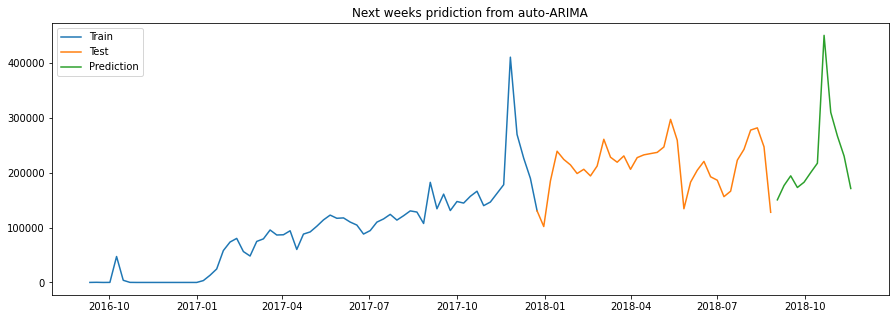

In [33]:
plt.figure(figsize=(15,5))
plt.ticklabel_format(useOffset=False, style='plain')
plt.plot(train, label = 'Train')
plt.plot(test, label = 'Test')
plt.plot(predict, label = 'Prediction')
plt.title('Next weeks pridiction from auto-ARIMA')
plt.legend(loc='best')
plt.show()

### Recency, Total Spent and Number of Purchases - Feature Creation

First, we are going to create 3 new features by calculating how long it has been since the customer made their last purchase, how much the customer spent in total with the site and how many purchases each customer made, all taking into account the last purchase in the dataset as a reference. So we can perform groupings later.

In [34]:
#Day of the week feature creation
data['weekDay'] = data.order_approved_at.dt.weekday

lastOrder = data.order_purchase_timestamp.max()

#Recency feature creation
print('Last order on the dataset is at:', lastOrder)

data['recency'] = ((lastOrder - data['order_purchase_timestamp']).dt.days)

#Frequency of purchases feature creation - How many unique orders does each customer have
data['totalOrders'] = data.groupby('customer_unique_id')['order_id'].transform('nunique')

#Total Spent feature creation
data['totalSpent'] = data.groupby('customer_unique_id')['price'].transform('sum')

Last order on the dataset is at: 2018-10-17 17:30:18


In [35]:
clusteringData = data[['customer_unique_id', 'totalOrders', 'totalSpent', 'recency']]

#group by the id and show the total orders and total spent, using the minimum recency when there are more than 2 orders.
clusteringData = clusteringData.loc[clusteringData.groupby('customer_unique_id').recency.idxmin()] #.set_index('customer_unique_id')

clusteringData

,customer_unique_id,totalOrders,totalSpent,recency
33312,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,160
89315,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,163
36238,0000f46a3911fa3c0805444483337064,1,69.00,585
38771,0000f6ccb0745a6a4b88665a16c9f078,1,25.99,369
8326,0004aac84e0df4da2b147fca70cf8255,1,180.00,336
...,...,...,...,...
64353,fffcf5a5ff07b0908bd4e2dbc735a684,1,1570.00,495
60904,fffea47cd6d3cc0a88bd621562a9d061,1,64.89,310
99246,ffff371b4d645b6ecea244b27531430a,1,89.90,617
11834,ffff5962728ec6157033ef9805bacc48,1,115.00,168


<AxesSubplot:title={'center':'Outliers from total Spent feature'}, xlabel='totalSpent'>

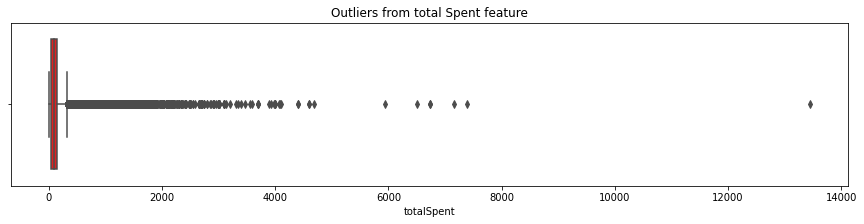

In [36]:
#Total Spent Outliers
plt.figure(figsize=(15,3))
plt.title('Outliers from total Spent feature')
sns.boxplot(x=clusteringData.totalSpent, color='red')

Old Shape:  (96096, 4)
Lower bound: -112.375
Upper bound: 315.265
New Shape:  (96096, 4)


<AxesSubplot:title={'center':'Total Spent features without outliers'}, xlabel='totalSpent'>

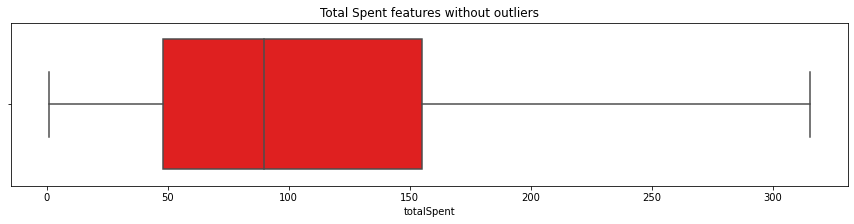

In [37]:
#Detect the outliers using IQR technique

q1 = clusteringData['totalSpent'].quantile(0.25)
q3 = clusteringData['totalSpent'].quantile(0.75)
iqr = q3 - q1
 
print("Old Shape: ", clusteringData.shape)
 
#Upper and Lower Limits
upper = q3 + 1.5 * iqr
lower = q1 - 1.5 * iqr

print("Lower bound:", lower)
print("Upper bound:", upper)
 
# new_df = data[data['Income'] > upper]
# new_df = data[data['Income']  < lower]

# Capping (above or below certain limit, all Incomes will be the same)

clusteringData['totalSpent'] = np.where(clusteringData['totalSpent'] > upper, upper, 
                               np.where(clusteringData['totalSpent'] < lower, lower,
                               clusteringData['totalSpent']))

print("New Shape: ", clusteringData.shape)

#distribution of Income without the greater outliers
plt.figure(figsize=(15,3))
plt.title('Total Spent features without outliers')
sns.boxplot(x=clusteringData['totalSpent'], color='red')

### Clustering of customers

We can now carry out the grouping of customers, assigning a score to each of the features created and applying the RFM technique.

In [38]:
#Function to process individual variables, calculate the elbow and Silhouette Scores and cluster by the feature.

def cluster_individual(data, column, invert=False):
    data = data
    columnName = str(column)
    className = "class_" + columnName
    X = data[column]
    X = pd.DataFrame(X)
    

    print('Results for clustering the feature:', columnName)
    

# n_clusters = 3

#Define the model using Elbow method to show best K value 
    kmeans_kwargs = {
        "n_clusters": 5,
        "init": "random",
        "n_init": 10,
        "max_iter": 300,
        "random_state": 1,
    }


    def sorted_cluster(x, model=None):
        if model == None:
            model = KMeans()
        model = sorted_cluster_centers_(model, x)
        model = sorted_labels_(model, x)
        return model

    def sorted_cluster_centers_(model, x):
        model.fit(x)
        new_centroids = []
        magnitude = []
        for center in model.cluster_centers_:
            magnitude.append(np.sqrt(center.dot(center)))
        idx_argsort = np.argsort(magnitude)
        model.cluster_centers_ = model.cluster_centers_[idx_argsort]
        return model

    def sorted_labels_(sorted_model, x):
        sorted_model.labels_ = sorted_model.predict(x)
        return sorted_model
    
 #--------> Sort Clusters 

    # Final model 
    km = KMeans(**kmeans_kwargs).fit(X)

    # assign a cluster to each
    # X[className] = km.fit_predict(X)
    cluster = sorted_cluster(X, km)
    X[className] = cluster.predict(X)



    #------Plot results of the clustering using the above K
    plt.figure(figsize=(15,3))
    plt.title('Results of clustering')

    sns.scatterplot(x=X[columnName], y=X.index, hue=X[className], s=30)
    
    #Append the clustering to the original DataSet
    data[className] = X[className] + 1

    if invert:
        data[className] = data[className].map({5:1,
                                            4:2,
                                            3:3,
                                            2:4,
                                            1:5})

    #return data   

Results for clustering the feature: recency


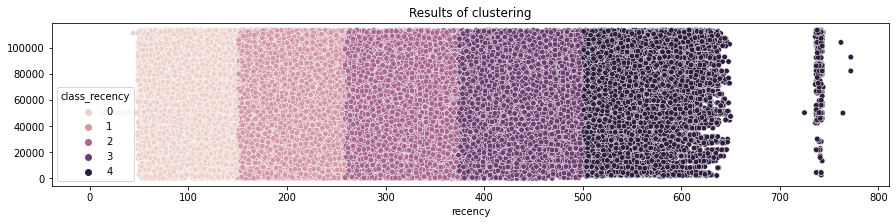

In [39]:
cluster_individual(clusteringData, 'recency', invert=True)

Results for clustering the feature: totalSpent


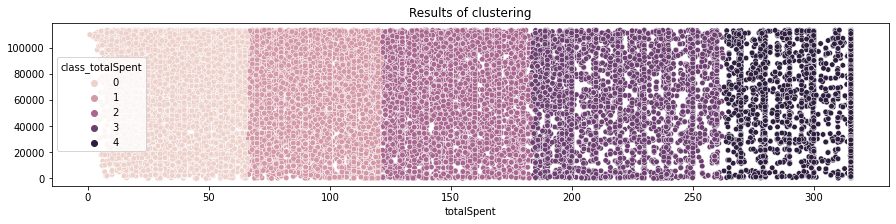

In [40]:
cluster_individual(clusteringData, 'totalSpent')

Results for clustering the feature: totalOrders


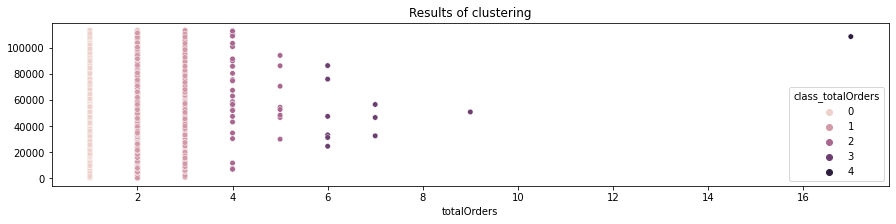

In [41]:
cluster_individual(clusteringData, 'totalOrders')

In [43]:
#RFM table

def segmentCustomers(data):
    fmMean = (data['class_totalOrders'] + data['class_totalSpent']) / 2
    
    if (data['class_recency'] >= 4) and (fmMean >= 4):
        return 'Champions'
    if (data['class_recency'] >= 2 and data['class_recency'] <= 5) and (fmMean >= 3 and fmMean <= 5):
        return 'Loyal Customers'
    if (data['class_recency'] >= 3 and data['class_recency'] <= 5) and (fmMean >= 1 and fmMean <= 3):
        return 'Potential Loyslist'
    if (data['class_recency'] >= 4 and data['class_recency'] <= 5) and (fmMean >= 0 and fmMean <= 1):
        return 'New Customers'
    if (data['class_recency'] >= 3 and data['class_recency'] <= 4) and (fmMean >= 0 and fmMean <= 1):
        return 'Promising'
    if (data['class_recency'] >= 2 and data['class_recency'] <= 3) and (fmMean >= 2 and fmMean <= 3):
        return 'Customer Needing Attention'
    if (data['class_recency'] >= 2 and data['class_recency'] <= 3) and (fmMean >= 0 and fmMean <= 2):
        return 'About to Sleep'
    if (data['class_recency'] >= 0 and data['class_recency'] <= 2) and (fmMean >= 2 and fmMean <= 5):
        return 'At Risk'
    if (data['class_recency'] >= 0 and data['class_recency'] <= 1) and (fmMean >= 4 and fmMean <= 5):
        return "Can't Lose Then"
    if (data['class_recency'] >= 1 and data['class_recency'] <= 2) and (fmMean >= 1 and fmMean <= 2):
        return 'Hibernating'
    return 'Lost'

clusteringData['customerSegment'] = clusteringData.apply(segmentCustomers, axis=1)

clusteringData['customerSegment']

33312    Potential Loyslist
89315    Potential Loyslist
36238           Hibernating
38771    Potential Loyslist
8326     Potential Loyslist
                ...        
64353       Loyal Customers
60904    Potential Loyslist
99246           Hibernating
11834    Potential Loyslist
9817            Hibernating
Name: customerSegment, Length: 96096, dtype: object

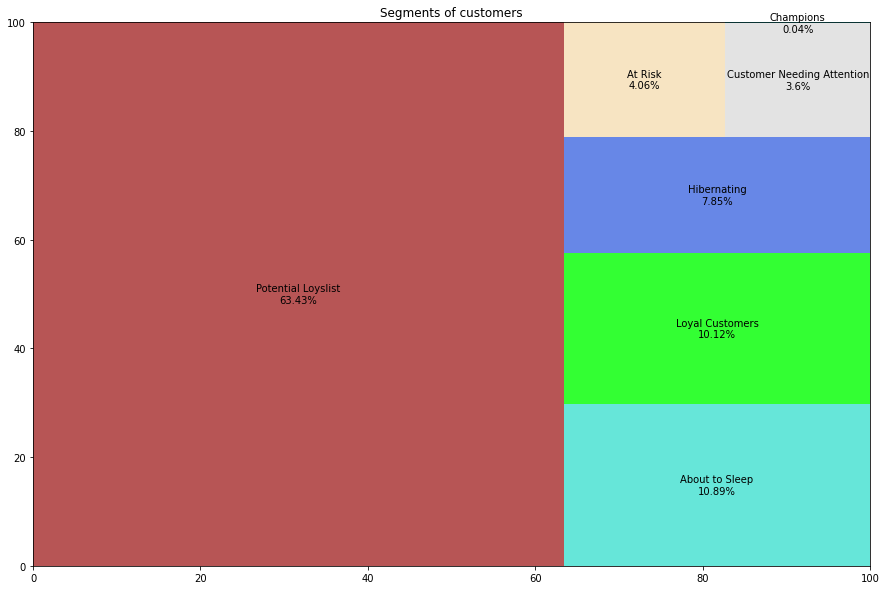

In [44]:
plotSeg = clusteringData['customerSegment'].value_counts(normalize=True)*100
plotSegIndex = plotSeg.reset_index()

lbl = (plotSeg.index[i] + "\n" + str(round(plotSeg[i], 2)) + '%' for i in range(len(plotSeg)))

# Define the plot sizes
fig, ax = plt.subplots(1, figsize = (15,10))
plt.title('Segments of customers')

sq.plot(sizes= plotSeg,
        color = ['brown','turquoise','lime','royalblue','wheat','gainsboro','aqua','indigo','sandybrown','pink','dodgerblue'],
        pad = False,
        label= lbl,
        alpha = .8)

plt.show()

In [47]:
clusteringData

,customer_unique_id,totalOrders,totalSpent,recency,class_recency,class_totalSpent,class_totalOrders,customerSegment
33312,0000366f3b9a7992bf8c76cfdf3221e2,1,129.900,160,4,3,1,Potential Loyslist
89315,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.900,163,4,1,1,Potential Loyslist
36238,0000f46a3911fa3c0805444483337064,1,69.000,585,1,2,1,Hibernating
38771,0000f6ccb0745a6a4b88665a16c9f078,1,25.990,369,3,1,1,Potential Loyslist
8326,0004aac84e0df4da2b147fca70cf8255,1,180.000,336,3,3,1,Potential Loyslist
...,...,...,...,...,...,...,...,...
64353,fffcf5a5ff07b0908bd4e2dbc735a684,1,315.265,495,2,5,1,Loyal Customers
60904,fffea47cd6d3cc0a88bd621562a9d061,1,64.890,310,3,1,1,Potential Loyslist
99246,ffff371b4d645b6ecea244b27531430a,1,89.900,617,1,2,1,Hibernating
11834,ffff5962728ec6157033ef9805bacc48,1,115.000,168,4,2,1,Potential Loyslist


### creating a new dataframe for dynamic pricing testing

In [65]:
data1= data[['customer_unique_id','order_purchase_timestamp', 'weekDay','product_id', 'product_category_name', 'price', 'recency', 'totalOrders', 'totalSpent']]
data2=clusteringData[['customer_unique_id', 'class_recency', 'class_totalSpent', 'class_totalOrders', 'customerSegment']]
df= pd.concat([data1, data2], axis=1)
df

,customer_unique_id,order_purchase_timestamp,weekDay,product_id,product_category_name,price,recency,totalOrders,totalSpent,customer_unique_id,class_recency,class_totalSpent,class_totalOrders,customerSegment
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,0.0,87285b34884572647811a353c7ac498a,utilidades_domesticas,29.99,380,2,65.38,7c396fd4830fd04220f754e42b4e5bff,2.0,1.0,2.0,About to Sleep
1,3a51803cc0d012c3b5dc8b7528cb05f7,2017-08-15 18:29:31,1.0,87285b34884572647811a353c7ac498a,utilidades_domesticas,29.99,427,1,29.99,3a51803cc0d012c3b5dc8b7528cb05f7,2.0,1.0,1.0,About to Sleep
2,ef0996a1a279c26e7ecbd737be23d235,2017-08-02 18:24:47,2.0,87285b34884572647811a353c7ac498a,utilidades_domesticas,29.99,440,1,29.99,ef0996a1a279c26e7ecbd737be23d235,2.0,1.0,1.0,About to Sleep
3,e781fdcc107d13d865fc7698711cc572,2017-10-23 23:26:46,2.0,87285b34884572647811a353c7ac498a,utilidades_domesticas,29.99,358,1,29.99,e781fdcc107d13d865fc7698711cc572,3.0,1.0,1.0,Potential Loyslist
4,02c9e0c05a817d4562ec0e8c90f29dba,2017-08-10 13:35:55,3.0,b00a32a0b42fd65efb58a5822009f629,bebes,75.90,433,1,75.90,02c9e0c05a817d4562ec0e8c90f29dba,2.0,2.0,1.0,About to Sleep
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113420,2077f7ec37df79c62cc24b7b8f30e8c9,2018-07-01 10:23:10,3.0,31ec3a565e06de4bdf9d2a511b822b4d,construcao_ferramentas_iluminacao,79.00,108,1,79.00,2077f7ec37df79c62cc24b7b8f30e8c9,5.0,2.0,1.0,Potential Loyslist
113421,78a159045124eb7601951b917a42034f,2017-03-11 19:51:36,5.0,241a1ffc9cf969b27de6e72301020268,automotivo,19.70,584,1,19.70,78a159045124eb7601951b917a42034f,1.0,1.0,1.0,Hibernating
113422,8cf3c6e1d2c8afaab2eda3fa01d4e3d2,2018-07-24 09:46:27,1.0,1d187e8e7a30417fda31e85679d96f0f,moveis_decoracao,399.00,85,1,399.00,8cf3c6e1d2c8afaab2eda3fa01d4e3d2,5.0,5.0,1.0,Loyal Customers
113423,e55e436481078787e32349cee9febf5e,2018-05-22 21:13:21,1.0,6e1c2008dea1929b9b6c27fa01381e90,moveis_decoracao,219.90,147,1,219.90,e55e436481078787e32349cee9febf5e,5.0,4.0,1.0,Potential Loyslist


In [66]:
df['productCategoryOrders'] = df['product_category_name'].value_counts().head(20)

In [67]:
import keras

In [69]:
X = df[['recency', 'order_purchase_timestamp', 'totalSpent','customerSegment']]
print(X)

        recency order_purchase_timestamp  totalSpent     customerSegment
0           380      2017-10-02 10:56:33       65.38      About to Sleep
1           427      2017-08-15 18:29:31       29.99      About to Sleep
2           440      2017-08-02 18:24:47       29.99      About to Sleep
3           358      2017-10-23 23:26:46       29.99  Potential Loyslist
4           433      2017-08-10 13:35:55       75.90      About to Sleep
...         ...                      ...         ...                 ...
113420      108      2018-07-01 10:23:10       79.00  Potential Loyslist
113421      584      2017-03-11 19:51:36       19.70         Hibernating
113422       85      2018-07-24 09:46:27      399.00     Loyal Customers
113423      147      2018-05-22 21:13:21      219.90  Potential Loyslist
113424      154      2018-05-15 17:41:00       15.50  Potential Loyslist

[113425 rows x 4 columns]


In [68]:
X = df[['recency', 'order_purchase_timestamp', 'totalSpent','customerSegment']]
y = ['price']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

NameError: name 'train_test_split' is not defined

In [ ]:
X = dataframe[['Recency', 'order_purchase_timestamp', 'totalSpent','segment', 'price']]
y = dataframe['price']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

#CNN using Keras
#Recency, order_purchase_timestamp,total spent, segment, price --> predicted price
#input dim = dataframe columns
nodes = 7
model = Sequential()
 model.add(Dense(nodes, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='relu'))
cnn_model = model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#fit model
cnn_model.fit(X, y, epochs=10, batch_size=32)
history = cnn_model.fit(X, y, epochs=10, batch_size=32)
 history_dict = history.history
# Plots model's training cost/loss and model's validation split cost/loss
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

plt.plot(loss_values, label='training loss')
plt.plot(val_loss_values, label='val loss')
plt.legend()
plt.show()